In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as dist

In [2]:
n = 50
np.random.seed(17)
mus = np.random.normal(5,2,n)
#mus[:int(n/4)] = np.random.normal(10, 1, int(n/4))

#mus = np.random.choice(mu_population, n)

In [3]:
Xs = np.random.normal(mus,1)

In [4]:
C_grid = np.linspace(min(Xs) - 3,max(Xs) + 3,2000)

F_1 = np.zeros(len(C_grid)).astype(float)
F_2 = np.zeros(len(C_grid)).astype(float)

for i in range(len(C_grid)):
    F_1[i] = Xs[Xs >= C_grid[i]].sum()
    
#width = 0.05
#ecdf = scipy.stats.ecdf(Xs)
#F_2 = len(Xs)*(ecdf.cdf.evaluate(C_grid + width) - ecdf.cdf.evaluate(C_grid - width))/(2*width)

d = Xs.reshape(-1,1) - C_grid.reshape(1,-1)
h_n = np.sqrt(np.log(n))
F_2 = (np.sin(h_n*d)/(np.pi*d)).sum(axis = 0) # another kernel estimate 
URE = F_1 - F_2


true_risk = np.zeros_like(C_grid)
for i in range(len(C_grid)):
    true_risk[i] = np.sum(mus*scipy.stats.norm.cdf(mus - C_grid[i]))

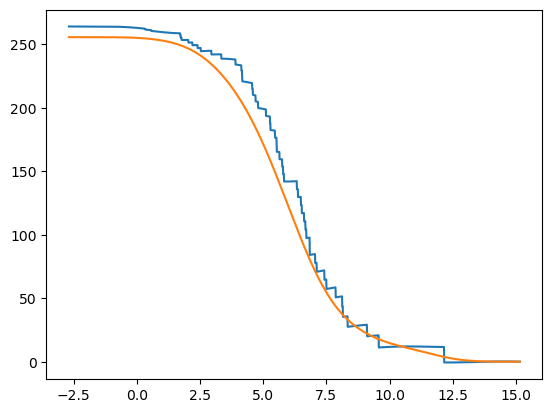

In [5]:
plt.plot(C_grid, URE)
plt.plot(C_grid, true_risk)

In [6]:
### Neural Network


# Define the model with Gaussian CDF activation
class OneLayerNN(nn.Module):
    def __init__(self, num_units):
        super().__init__()
        self.w = nn.Parameter(torch.randn(num_units))  # Shared weights and biases

    def gaussian_cdf(self, z):
        """Computes the Gaussian CDF using PyTorch's normal distribution."""
        return dist.Normal(0, 1).cdf(z)
    
    def forward(self, x):
        # Ensure x is a 1D tensor of shape (N,) where N=2000.
        # Expand dimensions for broadcasting:
        w_expanded = self.w.unsqueeze(0)  # Shape: (1, 200)
        x_expanded = x.unsqueeze(1)         # Shape: (2000, 1)

        # Now w_expanded - x_expanded will have shape (2000, 200)
        result = w_expanded * self.gaussian_cdf(w_expanded - x_expanded)

        # Sum over the hidden units dimension (the last dimension, 200)
        return torch.sum(result, dim=-1)


# Hyperparameters
num_units = n    # Number of hidden units
lr = 0.1         # Learning rate
epochs = 3000     # Number of training epochs

# Create model and optimizer
model = OneLayerNN(num_units)
optimizer = optim.Adam(model.parameters(), lr=lr)  # Change to SGD if needed
loss_fn = nn.MSELoss()

x_train = torch.tensor(C_grid, dtype=torch.float32)
y_train = torch.tensor(URE, dtype=torch.float32)

# Training loop
for epoch in range(epochs):
    optimizer.zero_grad()
    y_pred = model(x_train)
    loss = loss_fn(y_pred, y_train.squeeze())
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

print("Training complete.")


Epoch 0, Loss: 28907.8379
Epoch 100, Loss: 166.4135
Epoch 200, Loss: 29.2890
Epoch 300, Loss: 21.3430
Epoch 400, Loss: 18.9584
Epoch 500, Loss: 17.7978
Epoch 600, Loss: 15.6291
Epoch 700, Loss: 13.2470
Epoch 800, Loss: 12.5275
Epoch 900, Loss: 12.3583
Epoch 1000, Loss: 12.2783
Epoch 1100, Loss: 12.2301
Epoch 1200, Loss: 12.1989
Epoch 1300, Loss: 12.1775
Epoch 1400, Loss: 12.1623
Epoch 1500, Loss: 12.1511
Epoch 1600, Loss: 12.1426
Epoch 1700, Loss: 12.1360
Epoch 1800, Loss: 12.1306
Epoch 1900, Loss: 12.1261
Epoch 2000, Loss: 12.1221
Epoch 2100, Loss: 12.1184
Epoch 2200, Loss: 12.1149
Epoch 2300, Loss: 12.1115
Epoch 2400, Loss: 12.1082
Epoch 2500, Loss: 12.1047
Epoch 2600, Loss: 12.1012
Epoch 2700, Loss: 12.0976
Epoch 2800, Loss: 12.0938
Epoch 2900, Loss: 12.0899
Training complete.


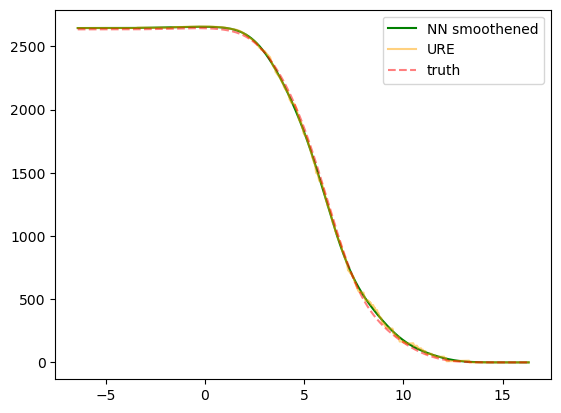

In [30]:
nn_smooth = y_pred.detach().numpy()
plt.plot(C_grid, nn_smooth, label="NN smoothened", color = 'green')
plt.plot(C_grid, URE, label="URE", alpha = 0.5, color = "orange")
plt.plot(C_grid, true_risk, label="truth", color = "red", linestyle = '--', alpha = 0.5)
plt.legend()

In [31]:
optimal_decision = C_grid[np.argmax(nn_smooth)]
print(optimal_decision)
print(mus[(Xs > optimal_decision)].sum())

true_opt = C_grid[np.argmax(true_risk)]
print(true_opt)
print(mus[(Xs > true_opt)].sum())

ure_opt = C_grid[np.argmax(URE)]
print(ure_opt)
print(mus[(Xs > ure_opt)].sum())

#selected = (Xs > optimal_decision)
#val = mus[selected].sum()

-0.19638007055333162
2644.6319537817208
-0.4351396962060834
2644.6319537817208
-0.10542402268561712
2645.552199019926
